# Estimacion de produccion de Aceite

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,12)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }
# plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import sys
sys.path.append('../serch_tools/')
import serch_tools as st

from pdpbox import pdp, info_plots
from sklearn.cluster import KMeans
import plotly
import cufflinks

In [3]:
# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

In [4]:
aforos = pd.read_csv("datos/aforos.csv")
analisis_fluidos = pd.read_csv("datos/Analisis_fluidos.csv")
columna_geologica = pd.read_csv('datos/columna_geologica.csv')
eval_petrofisica = pd.read_csv('datos/eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('datos/IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('datos/parametros_petrofisicos.csv')

In [5]:
datos_generales_pozos = pd.read_csv('datos/datos_generales_de_pozos.csv')
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[:6] + datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[8:]
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos['CLASIFICACION_LAHEE'].str.replace("/","-")

In [6]:
prod_mens = pd.read_csv('datos/produccion_mensual.csv')
prod_mens.head()

,index,NOMBRE_DEL_POZO,CIMA_INTERVALO_(md),BASE_INTERVALO_(md),CONDICION_DE_FLUJO_(Fluyente/SAP),FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa),RELACION_GAS_LIQUIDO_(m3/m3),RELACION_GAS_ACEITE_(m3/m3),CORTE_DE_AGUA_(bl/bl),SALINIDAD_(PPM),...,RELACION_CONDENSADO_GAS_(m3/m3),RELACION_AGUA_GAS_(m3/m3),RELACION_AGUA_CONDENSADO_(m3/m3),FRACCION_DEL_SEDIMENTO,DIAMETRO_DEL_ESTRANGULADOR _(in),VOLUMEN_DE_ACEITE_(m3),VOLUMEN_DE_GAS_(m3),VOLUMEN_DE_CONDENSADO_(m3),DIAS_DE_PRODUCCION,DESCRIPCION_DE_LA_PRODUCCION
0,0,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/10/2013,101.175571,203.152074,50.205197,SIN INFORMACION,...,NO APLICA,0.004962,NO APLICA,NO APLICA,NO APLICA,31.803914,6462.078342,NO APLICA,31,SIN INFORMACION
1,1,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/11/2013,100.298703,203.279313,50.667656,SIN INFORMACION,...,NO APLICA,0.005052,NO APLICA,NO APLICA,NO APLICA,29.536942,6005.222347,NO APLICA,30,SIN INFORMACION
2,2,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/12/2013,101.159166,203.859067,50.385933,SIN INFORMACION,...,NO APLICA,0.004981,NO APLICA,NO APLICA,NO APLICA,30.852725,6290.627114,NO APLICA,31,SIN INFORMACION
3,3,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/01/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,31.774044,6464.681785,NO APLICA,31,SIN INFORMACION
4,4,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/02/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,28.699137,5839.067419,NO APLICA,28,SIN INFORMACION


In [7]:
prod_mens.columns

Index(['index', 'NOMBRE_DEL_POZO', 'CIMA_INTERVALO_(md)',
       'BASE_INTERVALO_(md)', 'CONDICION_DE_FLUJO_(Fluyente/SAP)',
       'FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)', 'RELACION_GAS_LIQUIDO_(m3/m3)',
       'RELACION_GAS_ACEITE_(m3/m3)', 'CORTE_DE_AGUA_(bl/bl)',
       'SALINIDAD_(PPM)', 'RELACION_AGUA_ACEITE_(m3/m3)',
       'RELACION_CONDENSADO_GAS_(m3/m3)', 'RELACION_AGUA_GAS_(m3/m3)',
       'RELACION_AGUA_CONDENSADO_(m3/m3)', 'FRACCION_DEL_SEDIMENTO',
       'DIAMETRO_DEL_ESTRANGULADOR _(in)', 'VOLUMEN_DE_ACEITE_(m3)',
       'VOLUMEN_DE_GAS_(m3)', 'VOLUMEN_DE_CONDENSADO_(m3)',
       'DIAS_DE_PRODUCCION ', 'DESCRIPCION_DE_LA_PRODUCCION '],
      dtype='object')

In [8]:
prod_mens.groupby(['NOMBRE_DEL_POZO'])['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'].count().median()

121.0

In [9]:
prod_mens['fecha_produccion'] = pd.to_datetime(prod_mens['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'], 
                                               format="%d/%m/%Y")

In [10]:
prod_mens['fecha_produccion'].describe()

count                   20821
unique                    187
top       1999-01-01 00:00:00
freq                      156
first     1999-01-01 00:00:00
last      2014-07-01 00:00:00
Name: fecha_produccion, dtype: object

En algunos posos tenemos un historico de 1999 hasta 2014

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [11]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [12]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [13]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [14]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 6 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_1 P(t-2)+ \beta_1 P(t-3)+ \beta_1 P(t-4)+ \beta_1 P(t-5)+ \beta_1 P(t-6) + \epsilon$

In [15]:
# tabla (t-6)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t - 5)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

# tabla (t -4)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-2)

# tabla (t - 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-3)

# tabla (t - 2)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-4)

# tabla (t -1)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-5)

# tabla (t) variable a estimar
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-6)

# tabla (t + 1) se genera para quitar picos abajo o rellenarlo con media movil
t_7 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-7)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [16]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6],1).dropna()
df.columns = ['Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t']

In [17]:
df = pd.concat([df,t_7],1)
df.columns = ['Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t','Produccion_barriles_t_mas_1']

In [18]:
df.shape # numero de registros

(20886, 8)

In [19]:
df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1

df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1

df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']

In [20]:
df.columns

Index(['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1',
       'Produccion_barriles_t', 'Produccion_barriles_t_mas_1', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1'],
      dtype='object')

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [21]:
# desviacion estandar
df['std_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
# mediana
df['median_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
# minimo
df['min_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
#quantiles
df['q75_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
df['q25_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
df['q90_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
df['q10_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
#maximo
df['max_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

#rango
df['rango_t6_t1'] = df['max_t_6_t_1'] - df['min_t_6_t_1']

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor
+  rango Acota la produccion esperada para no sobreestimar
+ quantiles en 6 meses

In [22]:
# medias moviles
df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

Se crean variables de medias moviles

In [23]:
[['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1','std_t_6_t_1']]

[['Produccion_barriles_t_1',
  'Produccion_barriles_t',
  'Produccion_barriles_t_mas_1',
  'std_t_6_t_1']]

In [24]:
df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 5*df.std_t_6_t_1 > df.Produccion_barriles_t,1,0)

In [25]:
df[df.dummi_pico_bajo==1][['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1',
                           'std_t_6_t_1','media_movil_t_6_t_1']].head()

Produccion_barriles_t_1  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2004-08-01                         194.98   
MOLOACAN-102D 1999-06-01                         278.20   
              2001-08-01                         353.60   
              2002-03-01                         343.05   
              2006-03-01                         210.84   

                                Produccion_barriles_t  \
Pozo          fecha_produccion                          
MOLOACAN-1004 2004-08-01                       157.25   
MOLOACAN-102D 1999-06-01                       137.72   
              2001-08-01                       295.96   
              2002-03-01                       100.67   
              2006-03-01                       180.66   

                                Produccion_barriles_t_mas_1  std_t_6_t_1  \
Pozo          fecha_produccion                                             
MOLOACAN-1004 2004-08-01                             147.68     5.215265   
MOLOACAN-102D 1999-06-01                             158.48    19.174908   
              2001-08-01                             365.47     9.395236   
              2002-03-01                             171.54    16.882444   
              2006-03-01                             196.87     3.918645   

                                media_movil_t_6_t_1  
Pozo          fecha_produccion                       
MOLOACAN-1004 2004-08-01                 190.136667  
MOLOACAN-102D 1999-06-01                 289.156667  
              2001-08-01                 343.876667  
              2002-03-01                 346.775000  
              2006-03-01                 210.891667

In [26]:
df[df.dummi_pico_bajo==1].shape

(856, 34)

In [27]:
df = df[df.dummi_pico_bajo!=1]

In [28]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

dummie de mes

In [29]:
# tabla dummies_month
dummi_month = pd.get_dummies(db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6).dt.month.dropna().astype(int).dropna(),prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2002-06-01              1        0        0        0        0   
              2002-07-01              0        1        0        0        0   
              2002-08-01              0        0        1        0        0   
              2002-09-01              0        0        0        1        0   
              2002-10-01              0        0        0        0        1   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2002-06-01              0        0        0        0         0   
              2002-07-01              0        0        0        0         0   
              2002-08-01              0        0        0        0         0   
              2002-09-01              0        0        0        0         0   
              2002-10-01              0        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2002-06-01               0         0  
              2002-07-01               0         0  
              2002-08-01               0         0  
              2002-09-01               0         0  
              2002-10-01               0         0

In [30]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

## Si estuvo detenido

In [31]:
# detenido_mes_anterior = pd.DataFrame(np.where(((db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-6) - db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-5))/np.timedelta64(1,"D")) < 31, 1, 0), index=db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().index, columns=['detenido_mes_antes'])
# detenido_mes_anterior.head()

In [32]:
# df = pd.merge(df, detenido_mes_anterior, right_index=True, left_index=True)

# Latitud y longitud

In [33]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [34]:
df_train = df.reset_index().merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [35]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud
214,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,186.59,...,0,0,1,0,0,0,0,0,17.985929,-94.370707
215,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,197.52,...,0,0,0,1,0,0,0,0,17.985929,-94.370707
216,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,215.72,...,0,0,0,0,1,0,0,0,17.985929,-94.370707
217,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,185.47,...,0,0,0,0,0,1,0,0,17.985929,-94.370707
218,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,137.72,...,0,0,0,0,0,0,1,0,17.985929,-94.370707


In [36]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

# Variable de tecnologia
Se le pega el nombre del equipo de perforacion para saber si es mejor o peor para la produccion

In [37]:
# pegar a pozo nombre_equipo_perfo
nombre_equi_perfo = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['NOMBRE_EQUIPO_DE_PERFORACION'].first())
nombre_equi_perfo.reset_index(inplace=True)
nombre_equi_perfo.columns = ['Pozo','equipo_perforacion']
# se encontraron inconsistencias en la info
nombre_equi_perfo["equipo_perforacion"] = nombre_equi_perfo.equipo_perforacion.str.replace(
    "PM5597-","PM-5597").str.replace(
    "PM.-5597","PM-5597").str.replace(
    "PM.5599","PM-5599")
nombre_equi_perfo.head()

,Pozo,equipo_perforacion
0,MOLOACAN-1,SIN INFORMACION
1,MOLOACAN-101,SIN INFORMACION
2,MOLOACAN-102,SIN INFORMACION
3,MOLOACAN-102A,PM-5597
4,MOLOACAN-11,PM-111


In [38]:
df_train = df_train.merge(nombre_equi_perfo, how='left',on='Pozo').dropna()

In [39]:
df_train = pd.get_dummies(df_train, columns=['equipo_perforacion'])

In [40]:
df_train.shape

(19629, 64)

# variable clasificaccion LAHEE
La Clasificación Lahee, los pozos pueden ser identificados como:
+ Pozo Exploratorio
+ Pozos Productores
+ Pozos no Productores (Secos)
+ Pozos de Desarrollo
+ Pozo de Avanzada

Codigos

    07-07-01 - Pozo de desarrollo, productor aceite
    07-07-06 - Pozo de desarrollo, improductivo, invadido de agua salada
    07-07-13 - 07 Pozo de desarrollo
    07-07-04 - Pozo de desarrollo, productor incosteable
    07-07-07 - Pozo de desarrollo, improductivo seco
    04-04-01 - Pozo en busca de nueva acumulacion en campo ya productor, productor de aceite
    07-01-00 - 07 Pozo de desarrollo
    04-04-06 - Pozo en busca de nueva acumulacion en campo ya productor, improductivo, invadido de agua salada
    01-01-06 - Pozo en busca de nueva acumulacion, improductivo, invadido de agua salada
    SIN INFORMACION

Referencia de codigos https://bndh.gob.do/wp-content/uploads/2016/04/4.3-MEM-BNDH-RD-Tercer-Informe-de-Avances_v2-1.pdf

In [41]:
clasifi_lahee = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['CLASIFICACION_LAHEE'].first())
clasifi_lahee.reset_index(inplace=True)
clasifi_lahee.columns = ['Pozo','clasificacion_lahee']
clasifi_lahee.head()

,Pozo,clasificacion_lahee
0,MOLOACAN-1,07-07-01
1,MOLOACAN-101,07-07-07
2,MOLOACAN-102,07-07-06
3,MOLOACAN-102A,07-07-01
4,MOLOACAN-11,07-07-01


In [42]:
df_train = df_train.merge(clasifi_lahee, how='left',on='Pozo').dropna()

In [43]:
df_train = pd.get_dummies(df_train, columns=['clasificacion_lahee'])

In [44]:
df_train.shape

(19629, 66)

In [45]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_PM-5599,equipo_perforacion_PM-5620,equipo_perforacion_PM-5626,equipo_perforacion_PM-5627,equipo_perforacion_PM-73,equipo_perforacion_PM-78,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION
0,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,186.59,...,0,0,0,0,0,0,0,1,1,0
1,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,197.52,...,0,0,0,0,0,0,0,1,1,0
2,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,215.72,...,0,0,0,0,0,0,0,1,1,0
3,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,185.47,...,0,0,0,0,0,0,0,1,1,0
4,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,137.72,...,0,0,0,0,0,0,0,1,1,0


# pendiente pico historico

In [46]:
# df_d_prod = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-6).reset_index()
# db_prod_mol['fecha_y'] = df_d_prod.f_prod

In [47]:
# for i in db_prod_mol.groupby('Pozo')[['Qo_mes_b','fecha_produccion','fecha_y']]:
#     print(i[0])
#     print(i[1][i[1].fecha_produccion >= i[1].fecha_y])

In [48]:
# y_temp = []
# for i in sample_prod_data.groupby('API')['Liquid']:
# #     print(i[0])
# #     print(i[1][i[1].index >= idx_prod_max_api[i[0]]].sum())
#     y_temp.append([i[0], i[1][i[1].index >= idx_prod_max_api[i[0]]].sum()])

In [49]:
# idx_prod_max_api = prod_data_train.groupby('API').Liquid.idxmax()

In [50]:
# # AQUI SE CREA LA Y (se puede hacer lista de comprension)
# pico_temp = []
# for i in db_prod_mol.groupby('Pozo')['Qo_mes_b']:
#     pico_temp.append([i[0], i[1][i[1].fecha_produccion >= idx_prod_max_api[i[0]]].sum()])

In [51]:
# db_prod_mol.columns

In [52]:
# db_prod_mol.groupby('Pozo')[['fecha_produccion','f_prod']].last()

In [53]:
# db_prod_mol.groupby(
#     ['Pozo','fecha_produccion'])

In [54]:
df_train.shape

(19629, 66)

## Quitamos Outliers

In [55]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

In [56]:
df_train = df_train[df_train.Produccion_barriles_t > df_train.Produccion_barriles_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_barriles_t_1 > df_train.Produccion_barriles_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_2 > df_train.Produccion_barriles_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_3 > df_train.Produccion_barriles_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_4 > df_train.Produccion_barriles_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_5 > df_train.Produccion_barriles_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_6 > df_train.Produccion_barriles_t_6.quantile(0.001)]

In [57]:
df_train = df_train[df_train.Produccion_barriles_t < df_train.Produccion_barriles_t.quantile(0.99)]

In [58]:
df_train = df_train[df_train.Produccion_barriles_t_1 < df_train.Produccion_barriles_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_2 < df_train.Produccion_barriles_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_3 < df_train.Produccion_barriles_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_4 < df_train.Produccion_barriles_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_5 < df_train.Produccion_barriles_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_6 < df_train.Produccion_barriles_t_6.quantile(0.99)]

In [59]:
df_train.reset_index(inplace=True, drop=True)

In [60]:
df_train.shape

(18044, 66)

# Clustering Vemos que hay tipos de pozos con produccion similar

In [61]:
from sklearn.cluster import KMeans

In [62]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

In [63]:
num_cols = ['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1',
        
        'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
            
       'aceleracion_de_produccion _t3t2_t2t1', 
            'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 
            'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1',
         'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 
            #'detenido_mes_antes',
       'latitud', 'longitud', 
            'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION', 
            'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION']

In [64]:
df_std = (df_train[num_cols] - df_train[num_cols].mean()) / df_train[num_cols].std()

In [65]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_std)
    Sum_of_squared_distances.append(km.inertia_)

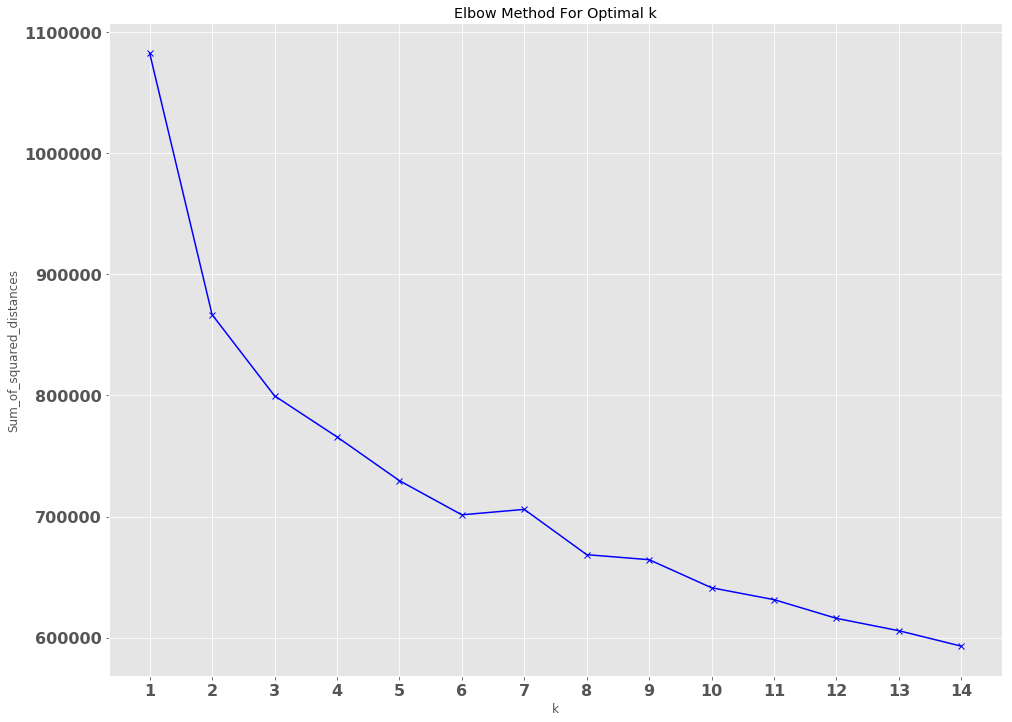

In [66]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(1,15));

In [67]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [68]:
df_train = pd.concat([df_train,pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [69]:
df_train["cluster"] = kmeans.predict(df_std)

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [70]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

# AED

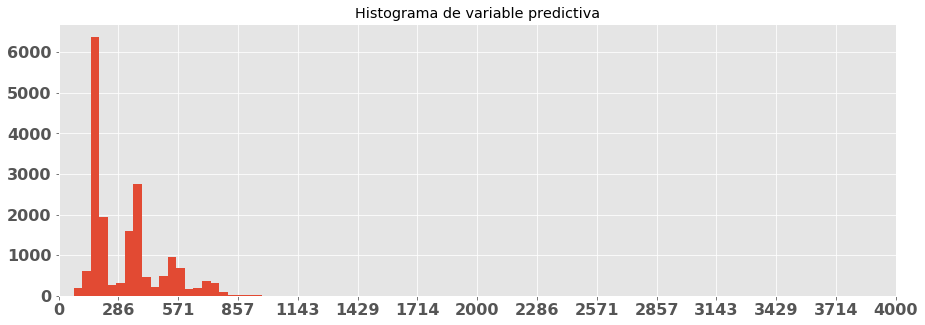

In [71]:
df_train.Produccion_barriles_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
plt.xticks(np.linspace(0,4000,15));

# Dispersiones

In [72]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

In [73]:
num_cols = ['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 
            'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 
            'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 
            #'detenido_mes_antes',
       'latitud', 'longitud',
            'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION', 'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION', 
            'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster']

En algun momento dibujaras un mapa aqui

In [74]:
lat = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
lon = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
idx = df_train.groupby('Pozo')[['latitud','longitud']].first().index.values

In [75]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

Text(0.5, 1.0, 'Observamos que hay pozos estables en cantidad de produccion y\n            otros que ascienden o descienden en produccion')

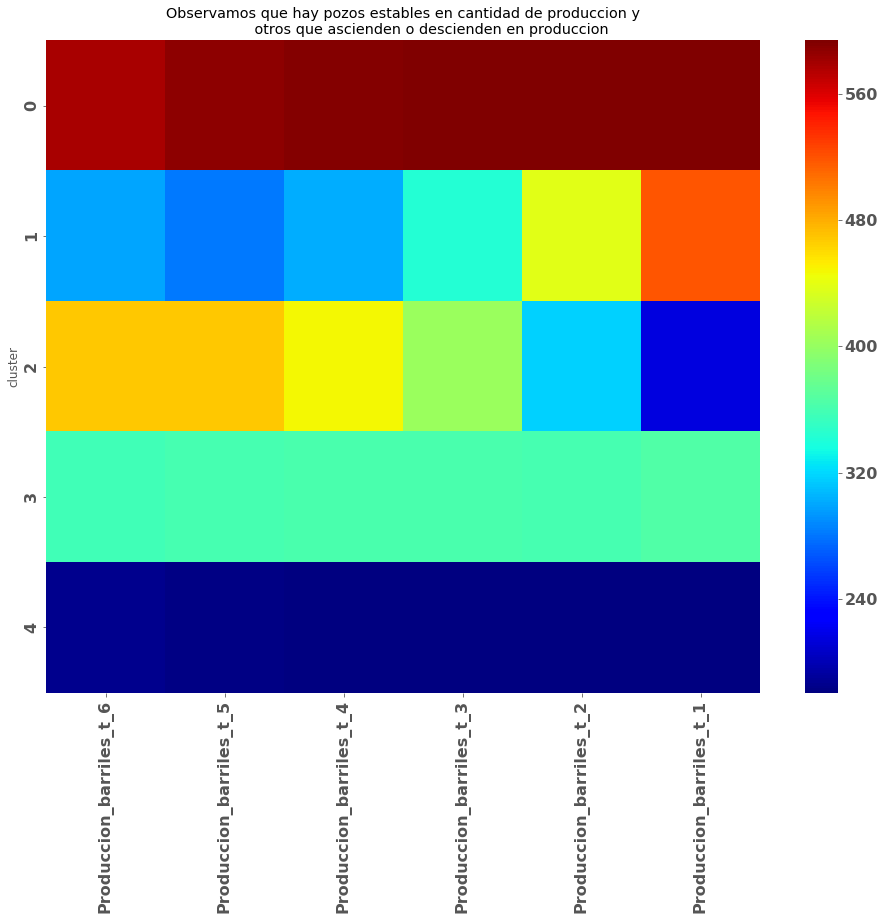

In [76]:
sns.heatmap(df_train.groupby('cluster')[[ 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1']].mean(),cmap='jet')
plt.title('''Observamos que hay pozos estables en cantidad de produccion y
            otros que ascienden o descienden en produccion''')

# Entrenamiento

Analisis con h2o no obtuvo mejores resultados, se carga el modelo light_gbm_31-07-2019.pkl

In [77]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

In [78]:
num_cols =['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 
           'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
           
       'aceleracion_de_produccion _t3t2_t2t1',
           'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 
           'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 
            'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12',
           #'detenido_mes_antes',
       'latitud', 'longitud',
           'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION',
           'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION', 
           'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4']

## AutoML h2o

In [79]:
import h2o

In [80]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.221-b11, mixed mode)
  Starting server from C:\Users\serch\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\serch\AppData\Local\Temp\tmpxfn32wyw
  JVM stdout: C:\Users\serch\AppData\Local\Temp\tmpxfn32wyw\h2o_serch_started_from_python.out
  JVM stderr: C:\Users\serch\AppData\Local\Temp\tmpxfn32wyw\h2o_serch_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/Mexico_City
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,8 months and 10 days !!!
H2O cluster name:,H2O_from_python_serch_v04yf1
H2O cluster total nodes:,1
H2O cluster free memory:,3.090 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [81]:
from h2o.automl import H2OAutoML

In [82]:
y='Produccion_barriles_t'

In [83]:
idx_valid = [5469, 6240, 10002, 835, 15796, 1795, 16313, 15401, 11518, 16082, 11863, 929, 12271, 15054, 10878, 6184, 331, 223, 17301, 5285, 7693, 2295, 16175, 11771, 16528, 14935, 6266, 7262, 14692, 10958, 13365, 11017, 1331, 16073, 10693, 8164, 16851, 6489, 15255, 16093, 7301, 14261, 13588, 13377, 4014, 7496, 5775, 8610, 16032, 8613, 13269, 1743, 1389, 14155, 12832, 10523, 5820, 273, 16223, 4573, 14566, 3952, 365, 6146, 9282, 9942, 7350, 1760, 14057, 14738, 4331, 14061, 1010, 3393, 16656, 1958, 6765, 17090, 17098, 7862, 18023, 13770, 111, 3923, 4842, 11545, 2092, 6474, 1175, 15391, 4398, 169, 13392, 13817, 6917, 17496, 16209, 8952, 13777, 14746, 9116, 9819, 4571, 7069, 17714, 243, 1123, 9695, 654, 2137, 5511, 5258, 2858, 9683, 13448, 2594, 14205, 16867, 4742, 4146, 4151, 2215, 4136, 2045, 7367, 1114, 8877, 6762, 12158, 11381, 9999, 3534, 6620, 15769, 16823, 6334, 7438, 5337, 1100, 15294, 15554, 7339, 2157, 5811, 13831, 890, 9086, 16870, 10816, 5281, 8093, 10100, 2993, 17320, 6650, 156, 4434, 14686, 17634, 15766, 16152, 15835, 6810, 932, 16700, 5193, 5947, 6098, 2236, 11996, 10362, 18013, 13190, 12145, 15166, 1989, 5365, 9400, 10003, 4196, 3742, 11362, 4874, 7152, 5741, 12538, 928, 1319, 9924, 8085, 17701, 7434, 3056, 4147, 10375, 288, 17427, 13676, 17642, 6891, 1774, 11520, 12189, 17219, 17052, 5453, 6535, 6586, 7504, 4020, 12990, 2041, 12947, 5215, 3460, 7790, 2573, 16119, 13927, 4754, 12992, 15288, 16755, 10680, 5884, 5508, 12431, 1188, 159, 11687, 10642, 8590, 9247, 3344, 2595, 3617, 13313, 9103, 4480, 4727, 3464, 13170, 6955, 14836, 12238, 8160, 16911, 9677, 16858, 7015, 9761, 4702, 12610, 7814, 17030, 7533, 942, 13804, 17447, 256, 3597, 12266, 15733, 6707, 3935, 8861, 9696, 3240, 12067, 10814, 2100, 2288, 15425, 5504, 5003, 7327, 16721, 7830, 15232, 10235, 10309, 11472, 11761, 13528, 12970, 3354, 7688, 3186, 13502, 7916, 16351, 10230, 12380, 1555, 13470, 3911, 6193, 4908, 11690, 3600, 9656, 268, 12086, 17308, 2410, 7626, 15250, 12222, 14391, 6012, 15888, 5666, 7567, 13043, 7347, 5879, 4884, 7609, 14440, 14242, 14760, 5813, 5120, 644, 2768, 17000, 6615, 13873, 7218, 15948, 4566, 1907, 782, 6168, 11584, 14677, 12639, 17671, 15562, 11628, 10441, 13308, 16100, 2282, 4116, 9914, 12399, 13953, 11710, 2551, 8623, 5283, 206, 4823, 15743, 4245, 3610, 12066, 6718, 11849, 8886, 5582, 2836, 13824, 7704, 7960, 3677, 11226, 4308, 10641, 14554, 17201, 13988, 1180, 8443, 8997, 7945, 4659, 12472, 1379, 17893, 5354, 8747, 2854, 18002, 15661, 6703, 1226, 16279, 13004, 15605, 16917, 12442, 10929, 5114, 6324, 18020, 9795, 8808, 15031, 2102, 6648, 8123, 7308, 7455, 6923, 7534, 12195, 14319, 17349, 8321, 10714, 799, 4121, 4327, 17983, 14126, 176, 2934, 10972, 5232, 3499, 4544, 16388, 3692, 4359, 12634, 17871, 15872, 9059, 9940, 9391, 3173, 15073, 1157, 8856, 12710, 12460, 15313, 6179, 10883, 4555, 11611, 945, 17961, 8201, 9363, 4924, 1550, 6661, 526, 3839, 11192, 5066, 10601, 12782, 17034, 14594, 15271, 17970, 9664, 4729, 5333, 9794, 4958, 14244, 9134, 3465, 1747, 4405, 14209, 676, 5254, 7400, 7989, 16725, 11478, 16278, 3246, 17311, 4316, 12950, 473, 56, 8440, 8393, 15533, 8324, 7479, 568, 11305, 4881, 14408, 2882, 4293, 15714, 11494, 4296, 10011, 10287, 16743, 9950, 4841, 11613, 4999, 5864, 2806, 1292, 1588, 12777, 7317, 5731, 10616, 12906, 16316, 1325, 5099, 2332, 10315, 1440, 17777, 1410, 17978, 14460, 13185, 13577, 15410, 2774, 17392, 3905, 6970, 436, 1013, 13340, 7028, 574, 13638, 12916, 2318, 1633, 1299, 11092, 11458, 9377, 1302, 9577, 10935, 5022, 15571, 1819, 8999, 8851, 14857, 13131, 8521, 8899, 16658, 13806, 3832, 10215, 14437, 7052, 17529, 15078, 10154, 5882, 969, 13163, 3431, 11453, 16935, 15732, 9509, 1261, 11279, 16381, 2965, 16126, 4123, 3727, 16053, 13720, 11310, 4845, 13083, 18033, 9295, 6622, 9371, 15737, 10384, 9556, 13897, 9629, 9648, 10821, 4917, 7478, 5004, 15858, 17303, 8088, 196, 1374, 2932, 16103, 11065, 4553, 13613, 11939, 7474, 1955, 4914, 17163, 16219, 15963, 7093, 6942, 9784, 3485, 12093, 5797, 12347, 1780, 15091, 15998, 2651, 10530, 11394, 15818, 4287, 17013, 5694, 2427, 5326, 7801, 896, 2713, 536, 5089, 11344, 17400, 1296, 13184, 15145, 10835, 16339, 9895, 8844, 10464, 3380, 2990, 15779, 3963, 9078, 13641, 15715, 9669, 14875, 14423, 11402, 10656, 13985, 5446, 13165, 15400, 7680, 13198, 15039, 15405, 1635, 2536, 5878, 7057, 16524, 1927, 13328, 11892, 7269, 7226, 5529, 1436, 6543, 12750, 10468, 3017, 29, 12030, 6205, 11735, 7557, 14683, 13834, 198, 6303, 3406, 209, 9579, 14719, 7014, 2310, 17803, 4338, 14110, 9884, 15305, 6500, 14842, 16327, 3632, 12640, 5430, 16742, 12516, 2582, 18041, 9229, 10431, 4749, 17592, 16230, 10008, 3766, 9240, 5720, 16546, 7639, 2664, 4997, 2133, 14203, 4168, 15668, 1970, 1453, 4707, 13666, 16458, 10701, 858, 8977, 12436, 16320, 17104, 933, 2097, 3706, 10974, 9393, 16723, 8678, 9464, 13449, 12065, 3681, 15443, 15347, 14632, 7449, 12501, 13353, 11946, 10365, 9529, 17505, 12849, 5040, 17195, 15827, 117, 7000, 13273, 9809, 14439, 16360, 4931, 443, 7709, 13084, 14422, 13879, 8789, 15049, 10921, 3386, 15721, 9902, 10501, 5889, 10871, 9221, 5873, 233, 7243, 4755, 15283, 4955, 1312, 15093, 14708, 11977, 106, 3009, 15586, 4543, 2615, 3646, 15007, 619, 544, 3752, 12457, 7047, 10415, 13619, 17347, 7798, 12671, 3862, 5950, 14910, 11138, 752, 11379, 14832, 7497, 10264, 1133, 12734, 4890, 15090, 11861, 12119, 682, 14278, 3396, 12863, 6858, 15870, 17247, 6578, 16815, 17235, 8985, 4363, 628, 17099, 11015, 17009, 9688, 4549, 17549, 13848, 17468, 14249, 8779, 9365, 17426, 1007, 1716, 4873, 6253, 11204, 12993, 14634, 10198, 10469, 11689, 1390, 16733, 7625, 6974, 9984, 1428, 17964, 15524, 1658, 3523, 943, 5163, 2249, 5569, 9855, 14450, 9286, 15503, 5587, 15445, 13935, 961, 2691, 10178, 3983, 1996, 4494, 13238, 3606, 17723, 10423, 6461, 6027, 14415, 10595, 4202, 2442, 10584, 9494, 10846, 9013, 15922, 17616, 967, 9249, 3245, 7185, 6122, 8065, 5059, 10249, 7861, 15132, 15988, 16006, 14673, 16767, 6640, 886, 5721, 837, 376, 5546, 5905, 6485, 9699, 2160, 3906, 6646, 4247, 7416, 2311, 907, 16355, 3274, 8208, 6865, 12987, 7012, 5049, 581, 15696, 5545, 11672, 12835, 1294, 16290, 803, 3996, 17429, 16525, 15613, 977, 5118, 3747, 112, 17779, 4765, 511, 8215, 7499, 547, 3435, 8009, 14264, 10212, 599, 13928, 14546, 3052, 10733, 17134, 3452, 12680, 6520, 14907, 8839, 11300, 10251, 6384, 8310, 849, 12383, 2153, 8620, 7744, 18022, 7834, 6464, 11307, 3462, 7723, 12076, 8473, 7821, 1844, 17486, 10794, 701, 7491, 3658, 13481, 13079, 8031, 3615, 9058, 8036, 5534, 10946, 14191, 9773, 17863, 16978, 15677, 8826, 7910, 7173, 4850, 6182, 13929, 13217, 12227, 10001, 1777, 11388, 624, 17073, 10024, 17040, 17316, 14753, 10613, 1531, 5250, 904, 798, 15052, 3891, 4225, 9369, 6595, 2005, 14214, 2892, 7736, 14226, 12978, 1701, 9060, 2486, 7081, 7150, 5515, 11266, 12021, 3739, 6208, 4110, 5178, 9706, 12682, 8030, 17774, 210, 17007, 7594, 1503, 13714, 7870, 1811, 12031, 12758, 54, 16542, 15472, 15614, 9481, 1579, 5443, 10926, 10785, 10256, 6251, 3300, 16860, 2184, 17025, 2335, 3987, 9938, 5392, 7655, 5304, 778, 3890, 13791, 3079, 8892, 13379, 13540, 14501, 12319, 3521, 11646, 1244, 14432, 8142, 5752, 5802, 5412, 17548, 5987, 13653, 8350, 15040, 87, 11395, 14, 7299, 1781, 3399, 8539, 7506, 16736, 6585, 7095, 10580, 13196, 3670, 12943, 14775, 3919, 5634, 14750, 5062, 7963, 4774, 9244, 6658, 310, 2383, 10687, 3776, 1231, 1982, 17704, 5977, 12621, 9670, 1354, 8584, 3941, 4190, 2731, 4126, 1318, 9694, 8989, 1820, 3295, 10450, 17850, 2234, 10619, 3036, 17026, 8710, 10455, 17611, 2697, 17127, 15106, 13223, 18010, 9627, 11324, 18001, 10435, 7546, 17590, 1146, 5562, 15032, 3811, 7333, 15642, 529, 8287, 7038, 1967, 14911, 16920, 13250, 979, 17081, 9159, 7891, 67, 12156, 7447, 17291, 11396, 5958, 11668, 15580, 12098, 10120, 10489, 4015, 17353, 7331, 8051, 2803, 15191, 9604, 13236, 13371, 14065, 15015, 3957, 6057, 7207, 10224, 4613, 9612, 16464, 3924, 13923, 12551, 1865, 1158, 11512, 10834, 5238, 2231, 10391, 17997, 18012, 464, 9006, 7176, 15920, 15094, 15646, 16402, 8001, 6314, 3038, 12083, 12991, 16877, 24, 11117, 14333, 8501, 6785, 3542, 14376, 2208, 4535, 11732, 4737, 1094, 15529, 1069, 4371, 14234, 6711, 5915, 5651, 6147, 11222, 2434, 2132, 7394, 16445, 8098, 4653, 6722, 8626, 15845, 17890, 3383, 9318, 9272, 13265, 16885, 11149, 1024, 5795, 6235, 16081, 16550, 12185, 15933, 15482, 13809, 3045, 9959, 7472, 1547, 7769, 1939, 7658, 15121, 4593, 17791, 3129, 4272, 12850, 9331, 10628, 12552, 1762, 10571, 1116, 15843, 5918, 14533, 12242, 12101, 15992, 5609, 3585, 5941, 6100, 14709, 1018, 8466, 9803, 13130, 13148, 17827, 11045, 16801, 2734, 1433, 13978, 17702, 9712, 10639, 13301, 3457, 8319, 9461, 13005, 12348, 11931, 14158, 13486, 15478, 6844, 16776, 3389, 15687, 5520, 16007, 6672, 12408, 4204, 1282, 1495, 8289, 1940, 10407, 9881, 17076, 4435, 2489, 15343, 12829, 10491, 690, 16952, 5436, 3029, 8470, 14635, 14102, 7460, 6409, 11, 4863, 3720, 3812, 306, 15632, 3243, 17576, 8114, 15246, 12615, 3539, 16047, 11759, 8417, 7233, 10851, 9426, 9660, 16803, 14943, 1551, 679, 13569, 3728, 9979, 8303, 3555, 14237, 396, 17882, 5185, 4607, 5327, 5757, 3215, 4640, 13485, 11260, 580, 4259, 9234, 15912, 2901, 16487, 9765, 3819, 11860, 16102, 6899, 10950, 16961, 2533, 13887, 4154, 2155, 8593, 10037, 4664, 9167, 6115, 16448, 5633, 10257, 2306, 13407, 409, 14957, 14491, 3900, 51, 237, 11987, 88, 12956, 9160, 1647, 13197, 16248, 16847, 4741, 9245, 141, 5401, 16358, 15704, 17159, 16989, 1153, 3680, 13294, 887, 6577, 16591, 12986, 1917, 7684, 12395, 6930, 15320, 8344, 7725, 3469, 3216, 11634, 16894, 17142, 11810, 11984, 15311, 6218, 14720, 5519, 1852, 13982, 6112, 3913, 8712, 16229, 15953, 10588, 1174, 11455, 14145, 8835, 13627, 11640, 5606, 12569, 2416, 3345, 15899, 9343, 13511, 8254, 13740, 9023, 10917, 16423, 499, 13067, 4408, 3334, 5831, 3106, 1957, 1711, 2087, 15741, 12801, 1176, 1908, 1992, 3666, 4031, 13941, 11091, 17249, 52, 7806, 2220, 14516, 9875, 15151, 10791, 12328, 13532, 2052, 13850, 9479, 12204, 107, 420, 7851, 6621, 9893, 6998, 4801, 17022, 17731, 8220, 8781, 1966, 1543, 4312, 4875, 2671, 7112, 11662, 4001, 3734, 16619, 691, 17125, 5640, 17752, 4058, 12357, 11796, 5783, 9374, 5724, 13410, 14783, 6892, 10095, 15946, 5460, 11873, 3981, 17309, 12753, 1882, 7750, 6293, 12405, 14224, 12897, 6032, 13478, 10498, 15817, 16466, 12362, 16560, 1323, 246, 7973, 17995, 8095, 12144, 8563, 15647, 6365, 14925, 807, 3314, 15925, 3861, 10416, 14293, 10793, 10990, 6284, 3026, 823, 13876, 14186, 8760, 2808, 15813, 13444, 6979, 1858, 8204, 11823, 14736, 10587, 8368, 8467, 520, 10425, 15442, 12659, 4279, 5223, 2557, 4440, 3973, 15350, 9554, 8027, 14617, 1000, 11871, 7356, 12553, 11410, 1166, 5897, 7905, 2590, 17489, 7786, 8664, 4200, 17191, 17274, 5222, 17430, 8078, 5739, 1833, 10699, 6957, 1485, 1944, 11566, 11116, 1619, 10077, 16088, 9467, 18021, 9378, 10626, 3217, 3708, 10981, 5109, 13601, 7883, 12514, 9225, 14512, 3258, 9856, 11078, 6947, 15319, 17768, 3004, 13919, 5021, 89, 16317, 13135, 6510, 13576, 1916, 15014, 14455, 10932, 5535, 7397, 10199, 7361, 14668, 14781, 11425, 774, 2376, 16643, 13943, 12474, 1159, 10274, 13248, 7217, 13678, 7923, 15381, 17137, 9933, 13046, 8025, 8168, 1400, 12567, 1330, 9250, 13748, 8495, 1873, 2862, 6494, 5347, 6415, 8023, 2787, 733, 5242, 10353, 5423, 12265, 6538, 16498, 11947, 11488, 7390, 13175, 468, 10704, 9265, 2305, 7409, 15651, 14876, 7055, 1326, 13745, 5063, 3774, 3247, 11839, 16178, 1610, 3100, 10035, 3122, 1768, 2634, 16319, 3491, 14248, 14411, 13728, 8754, 8083, 3409, 5749, 2135, 1383, 7708, 6207, 8721]

In [84]:
# pasar DataFrame a un objeto de h2o
dfh=h2o.H2OFrame(df_train[df_train.index.isin(idx_valid) == False][num_cols+['Produccion_barriles_t']])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [85]:
valid=h2o.H2OFrame(df_train[df_train.index.isin(idx_valid)][num_cols+['Produccion_barriles_t']])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [86]:
dfh.shape

(16239, 66)

In [87]:
valid.shape

(1805, 66)

In [88]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

In [89]:
train.columns

NameError: name 'train' is not defined

In [ ]:
# separar datos en train y test sets
splits = dfh.split_frame(ratios = [0.8,0.1], seed = 1)
train = splits[0]
test = splits[1]
pre_valid = splits[2]

In [ ]:
# definición de los algoritmos, correr algoritmos
aml = H2OAutoML(max_runtime_secs = 7200, seed = 1,
                project_name = "cluster_production",
                sort_metric='MAE')
aml.train(y = y, 
          training_frame = train,
          validation_frame = test)

In [ ]:
aml.leaderboard.head()

In [ ]:
aml.leader.model_performance(valid)

In [ ]:
lb=aml.leaderboard
lb.head(rows=lb.nrows)

In [ ]:
aml.leader
# .as_dataframe()

In [ ]:
#x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, num_cols, 'Produccion_barriles_t')

In [ ]:
x_train.shape

In [ ]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.8
params['num_leaves'] = 25
params['min_data'] = 10
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 100, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

In [ ]:
clf.num_trees()

# Optimizacion de Hiperparametros

In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
#gs.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

In [ ]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [ ]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

# Evaluacion

In [ ]:
#y_pred = clf.predict(x_valid)

In [ ]:
y_pred=aml.predict(valid)

In [ ]:
# transformar h2o a un DataFrame
y_pred = h2o.as_list(y_pred, use_pandas=True).values
y_valid = h2o.as_list(valid['Produccion_barriles_t'], use_pandas=True).values

In [ ]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("$R^2$: %1.4f" % R2)
    
    print("$R^2$ ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))

In [ ]:
report_evaluation_regression(y_valid, y_pred, df_train.shape[1])

In [ ]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

In [ ]:
yy_plot(y_valid, y_pred)

## Residuos

In [ ]:
res = (y_valid - y_pred) / y_valid

In [ ]:
plt.scatter(y_valid, res, alpha=0.5)

In [ ]:
pd.DataFrame(res).median() * 100

In [ ]:
res.mean() * 100

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

In [ ]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [ ]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [ ]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [ ]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Check de pozos aleatorios

In [ ]:
idx = df_train.Pozo.sample(10)

In [ ]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().index

In [ ]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().unstack(0)

In [ ]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [ ]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

In [ ]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [ ]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [ ]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_barriles_t

In [ ]:
df_train['prediction'] = preds

In [ ]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [ ]:
df_train.groupby('Pozo').fecha_produccion.count().median()

In [ ]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [ ]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [ ]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [ ]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10)

In [ ]:
# df_vivos2.columns = ['Produccion_promedio', 'prediction', 'prediccion_q90', 'prediccion_q10']

In [ ]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

# Carga de modelo

In [90]:
from sklearn.externals import joblib

In [91]:
# carga de modelo
gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Generador de serie de tiempo

In [92]:
df_simul = df_train[df_train.Pozo == 'MOLOACAN-836'].reset_index(drop=True)
#df_simul.drop(['Qomes_b_t_log','cluster'], 1, inplace=True)
df_simul.drop(['cluster'], 1, inplace=True)
df_simul['y_real'] = df_simul.Produccion_barriles_t

In [93]:
df_simul.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

In [94]:
# variables a utilizar
num_cols=['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longitud',
       'equipo_perforacion_PM-113', 'equipo_perforacion_PM-472',
       'equipo_perforacion_PM-504', 'equipo_perforacion_PM-5571',
       'equipo_perforacion_PM-5596', 'equipo_perforacion_PM-5597',
       'equipo_perforacion_PM-5599', 'equipo_perforacion_PM-5620',
       'equipo_perforacion_PM-5626', 'equipo_perforacion_PM-5627',
       'equipo_perforacion_PM-73', 'equipo_perforacion_PM-78',
       'equipo_perforacion_PM-92', 'equipo_perforacion_SIN INFORMACION',
       'clasificacion_lahee_07-07-01', 'clasificacion_lahee_SIN INRMACION',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4']

In [97]:
n_pred=3
lag=7
columna_inicial=2


In [98]:
df_prueba.tail()

NameError: name 'df_prueba' is not defined

In [99]:
pred

NameError: name 'pred' is not defined

# Prueba Forecasting

In [100]:
df_train.Pozo.sample(2)

13869    MOLOACAN-661
10279    MOLOACAN-485
Name: Pozo, dtype: object

In [149]:
df_prueba = df_train[df_train.Pozo == 'MOLOACAN-661'].reset_index(drop=True)
df_prueba['y_real'] = df_prueba.Produccion_barriles_t

In [150]:
df_prueba.shape

(138, 73)

In [151]:
# toma los primeros 6 meses
df_simul=df_prueba.iloc[0:6]
df_simul

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster,y_real
0,MOLOACAN-661,1999-01-01,593.28,554.47,612.23,473.03,659.13,592.53,375.82,375.14,...,0,1,0,0,0,1,0,0,2,375.82
1,MOLOACAN-661,1999-02-01,554.47,612.23,473.03,659.13,592.53,375.82,375.14,365.89,...,0,1,0,0,0,1,0,0,2,375.14
2,MOLOACAN-661,1999-03-01,612.23,473.03,659.13,592.53,375.82,375.14,365.89,396.59,...,0,1,0,0,0,1,0,0,2,365.89
3,MOLOACAN-661,1999-04-01,473.03,659.13,592.53,375.82,375.14,365.89,396.59,426.85,...,0,1,0,0,1,0,0,0,1,396.59
4,MOLOACAN-661,1999-05-01,659.13,592.53,375.82,375.14,365.89,396.59,426.85,529.49,...,0,1,0,0,1,0,0,0,1,426.85
5,MOLOACAN-661,1999-06-01,592.53,375.82,375.14,365.89,396.59,426.85,529.49,563.68,...,0,1,0,0,1,0,0,0,1,529.49


In [152]:
n_pred=df_prueba.shape[0]-6
lag=7
columna_inicial=2
df_simul,pred=forecast(df_simul,n_pred,lag,columna_inicial,num_cols)
df_simul['fecha_produccion']=df_prueba['fecha_produccion']

In [162]:
df_simul.tail(10)

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster,y_real
128,MOLOACAN-661,2013-09-01,583.986017,590.440037,579.605008,580.931495,575.260588,567.559337,572.410363,563.68,...,0,1,0,0,1,0,0,0,1,NaN
129,MOLOACAN-661,2013-10-01,590.440037,579.605008,580.931495,575.260588,567.559337,572.410363,570.272372,563.68,...,0,1,0,0,1,0,0,0,1,NaN
130,MOLOACAN-661,2013-11-01,579.605008,580.931495,575.260588,567.559337,572.410363,570.272372,557.816759,563.68,...,0,1,0,0,1,0,0,0,1,NaN
131,MOLOACAN-661,2013-12-01,580.931495,575.260588,567.559337,572.410363,570.272372,557.816759,562.407115,563.68,...,0,1,0,0,1,0,0,0,1,NaN
132,MOLOACAN-661,2014-01-01,575.260588,567.559337,572.410363,570.272372,557.816759,562.407115,566.849865,563.68,...,0,1,0,0,1,0,0,0,1,NaN
133,MOLOACAN-661,2014-02-01,567.559337,572.410363,570.272372,557.816759,562.407115,566.849865,556.708708,563.68,...,0,1,0,0,1,0,0,0,1,NaN
134,MOLOACAN-661,2014-03-01,572.410363,570.272372,557.816759,562.407115,566.849865,556.708708,557.566806,563.68,...,0,1,0,0,1,0,0,0,1,NaN
135,MOLOACAN-661,2014-05-01,570.272372,557.816759,562.407115,566.849865,556.708708,557.566806,563.781119,563.68,...,0,1,0,0,1,0,0,0,1,NaN
136,MOLOACAN-661,2014-06-01,557.816759,562.407115,566.849865,556.708708,557.566806,563.781119,564.196790,563.68,...,0,1,0,0,1,0,0,0,1,NaN
137,MOLOACAN-661,2014-07-01,562.407115,566.849865,556.708708,557.566806,563.781119,564.196790,562.123362,563.68,...,0,1,0,0,1,0,0,0,1,562.123362


In [163]:
df_prueba.tail(10)

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster,y_real
128,MOLOACAN-661,2013-09-01,186.18,192.64,135.44,187.26,192.28,173.60,191.14,183.19,...,0,1,0,1,0,0,0,0,0,191.14
129,MOLOACAN-661,2013-10-01,192.64,135.44,187.26,192.28,173.60,191.14,183.19,192.28,...,0,1,0,1,0,0,0,0,0,183.19
130,MOLOACAN-661,2013-11-01,135.44,187.26,192.28,173.60,191.14,183.19,192.28,186.07,...,0,1,0,1,0,0,0,0,0,192.28
131,MOLOACAN-661,2013-12-01,187.26,192.28,173.60,191.14,183.19,192.28,186.07,192.28,...,0,1,0,1,0,0,0,0,0,186.07
132,MOLOACAN-661,2014-01-01,192.28,173.60,191.14,183.19,192.28,186.07,192.28,285.27,...,0,1,0,1,0,0,0,0,0,192.28
133,MOLOACAN-661,2014-02-01,173.60,191.14,183.19,192.28,186.07,192.28,285.27,105.70,...,0,1,0,1,0,0,0,0,0,285.27
134,MOLOACAN-661,2014-03-01,191.14,183.19,192.28,186.07,192.28,285.27,105.70,18.67,...,0,1,0,1,0,0,0,0,0,105.70
135,MOLOACAN-661,2014-05-01,192.28,186.07,192.28,285.27,105.70,18.67,186.94,176.09,...,0,1,0,1,0,0,0,0,0,186.94
136,MOLOACAN-661,2014-06-01,186.07,192.28,285.27,105.70,18.67,186.94,176.09,190.26,...,0,1,0,1,0,0,0,0,0,176.09
137,MOLOACAN-661,2014-07-01,192.28,285.27,105.70,18.67,186.94,176.09,190.26,178.86,...,0,1,0,1,0,0,0,0,0,190.26


In [155]:
pred

[593.6602179686821,
 617.2427887359119,
 677.1642783598298,
 738.1300205658301,
 743.4441898814553,
 729.0620589079302,
 700.9571373592306,
 689.8386859171476,
 660.0029452869321,
 603.3378765552008,
 614.2550330577587,
 611.2111172664248,
 583.8612608218426,
 600.4959415429928,
 600.1453401475846,
 538.7060279268468,
 551.9230840786079,
 565.1193666449892,
 556.2024946129578,
 546.1111011797084,
 564.4727809268663,
 561.1730213893655,
 578.50522838791,
 570.194501367389,
 582.0320036605243,
 582.1093152808688,
 578.9013782927656,
 583.627869923883,
 576.2276371043928,
 563.3605268584448,
 571.7092641830294,
 562.257101812019,
 552.9326246742738,
 553.767626693328,
 551.4369030165515,
 547.3764766830408,
 552.5438077257304,
 563.7354745987043,
 554.0883615184803,
 550.8350198177477,
 549.7361573172867,
 556.3154634274223,
 557.8852371608601,
 562.8021392932848,
 558.1973597226456,
 564.893656786938,
 572.6854543667814,
 575.8754537941315,
 577.9570285648838,
 581.388258726419,
 578.0740134341972,
 583.9054305386696,
 573.685072891439,
 560.8719319673761,
 569.7323175360476,
 564.181836265009,
 555.7326407790094,
 552.750537333921,
 560.3311431087583,
 568.1061380799789,
 549.8344257992115,
 551.5335090960076,
 545.5684722748064,
 553.5986611771427,
 557.3559728242307,
 555.7753777695641,
 541.8597265056321,
 561.7210179349147,
 562.5605129997859,
 587.0546501826184,
 564.885313862209,
 597.52620278992,
 573.294376545396,
 594.7564113907632,
 611.735737286057,
 618.185329752853,
 604.6864248633676,
 585.0074292556291,
 559.6779075757936,
 574.1508750507505,
 570.8306707100927,
 558.7076261612856,
 587.2787600978447,
 573.5663911887822,
 575.5265461098004,
 580.2845357076496,
 563.8215750404132,
 567.8992746017948,
 572.609131395961,
 556.7397786776409,
 564.2109176768655,
 571.1579820515511,
 558.3265258663158,
 564.8626787297085,
 569.3909133176243,
 567.72755759496,
 573.4444770376031,
 574.2324198585112,
 565.4956063025413,
 577.9199221844923,
 567.9461727688844,
 564.3214792037136,
 566.4508208092296,
 554.2755326145751,
 542.2660080664846,
 556.8161530858227,
 561.7682673763393,
 549.5372326286556,
 547.212439261533,
 555.1209382687526,
 549.6044185266386,
 556.5511081907573,
 572.0839564799782,
 559.6317987818755,
 585.0859495666507,
 567.6987176946224,
 583.986017156778,
 590.4400374096138,
 579.6050078079561,
 580.9314945056739,
 575.2605878484943,
 567.5593372044343,
 572.4103627812034,
 570.2723716605145,
 557.8167591355352,
 562.4071145419019,
 566.8498654161353,
 556.708708357549,
 557.566805519289,
 563.781119005911,
 564.1967903914124,
 562.1233618052865]

In [156]:
len(pred)

132

In [157]:
df_simul[["Produccion_barriles_t_2","Produccion_barriles_t_1"]].head(10)

,Produccion_barriles_t_2,Produccion_barriles_t_1
0,659.130000,592.530000
1,592.530000,375.820000
2,375.820000,375.140000
3,375.140000,365.890000
4,365.890000,396.590000
5,396.590000,426.850000
6,426.850000,529.490000
7,529.490000,593.660218
8,593.660218,617.242789
9,617.242789,677.164278


In [158]:
df_simul['diff_t_2_t_1'].head(10)

0     66.600000
1    216.710000
2      0.680000
3      9.250000
4    -30.700000
5    -30.260000
6   -102.640000
7    -64.170218
8    -23.582571
9    -59.921490
Name: diff_t_2_t_1, dtype: float64

In [159]:
df_prueba['diff_t_2_t_1'].head(10)

0     66.60
1    216.71
2      0.68
3      9.25
4    -30.70
5    -30.26
6   -102.64
7    -34.19
8     41.47
9    -48.72
Name: diff_t_2_t_1, dtype: float64

In [160]:
df_prueba.index

RangeIndex(start=0, stop=138, step=1)

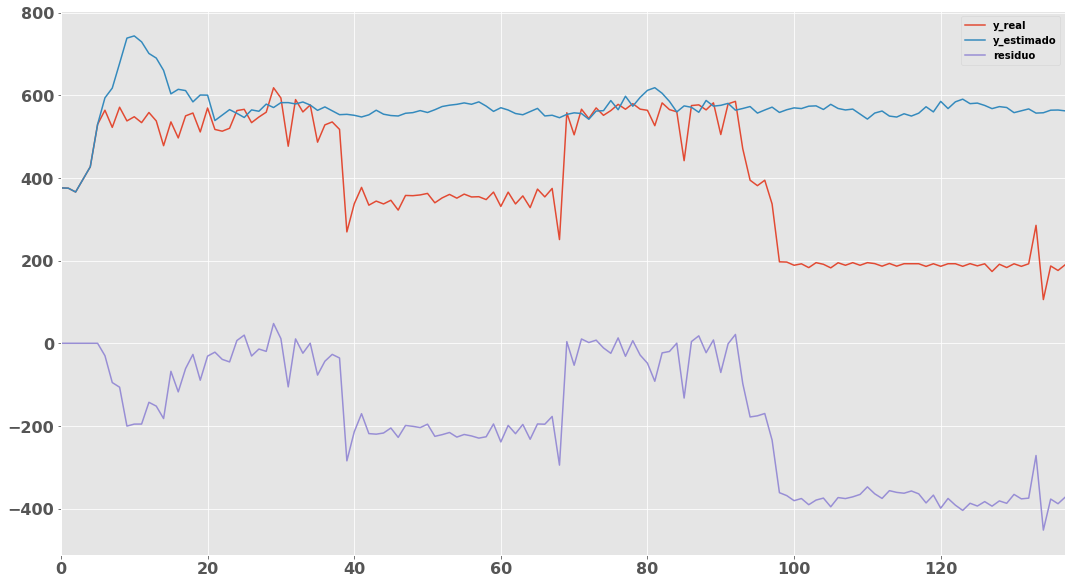

In [161]:
algo = pd.concat([df_prueba[["Produccion_barriles_t"]],df_simul[["Produccion_barriles_t"]]], 1)

algo.columns = ["y_real","y_estimado"]
algo["residuo"] = algo.y_real - algo.y_estimado

algo.plot(figsize=(18,10))

In [217]:
algo.iplot()

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

# Forecasting

Forecasting para todos los pozos activos

In [232]:
# pozos vivos
print(df_train.groupby('Pozo').fecha_produccion.count().median())
# aproximandamente 10 mediciones por pozo
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 110].index
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

105.5


In [234]:
df_vivos = df_vivos[df_vivos.fecha_produccion >= '2012-01-01']

In [235]:
df_forcast = df_train[df_train.fecha_produccion >= '2012-01-01']

In [236]:
pozos_cero = df_forcast.groupby('Pozo').fecha_produccion.min()[
    df_forcast.groupby('Pozo').fecha_produccion.min() == '2012-01-01'].index

In [237]:
df_vivos = df_vivos[df_vivos.Pozo.isin(pozos_cero)]

In [238]:
df_forcast = df_forcast[df_forcast.Pozo.isin(df_vivos.Pozo.unique())]

## Funciones para generar variables

In [246]:
def gen_cols(df):
    
    df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
    df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
    df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
    df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2
    df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1

    df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
    df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
    df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
    df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1

    df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
    df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']
    
    # desviacion estandar
    df['std_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
    # mediana
    df['median_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
    # minimo
    df['min_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
    #quantiles
    df['q75_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
    df['q25_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
    df['q90_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
    df['q10_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
    #maximo
    df['max_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

    #rango
    df['rango_t6_t1'] = df['max_t_6_t_1'] - df['min_t_6_t_1']
    
    # medias moviles
    df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                    'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                                   'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

    df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                                   'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    
    #dummi pico abajo
    #df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 5*df.std_t_6_t_1 > df.Produccion_barriles_t,1,0)
    
    # dummies_month
    #pd.get_dummies(df.reset_index().fecha_produccion.dt.month,prefix='month')
    
    #y_real
    df['y_real'] = df_simul.Produccion_barriles_t

    return df

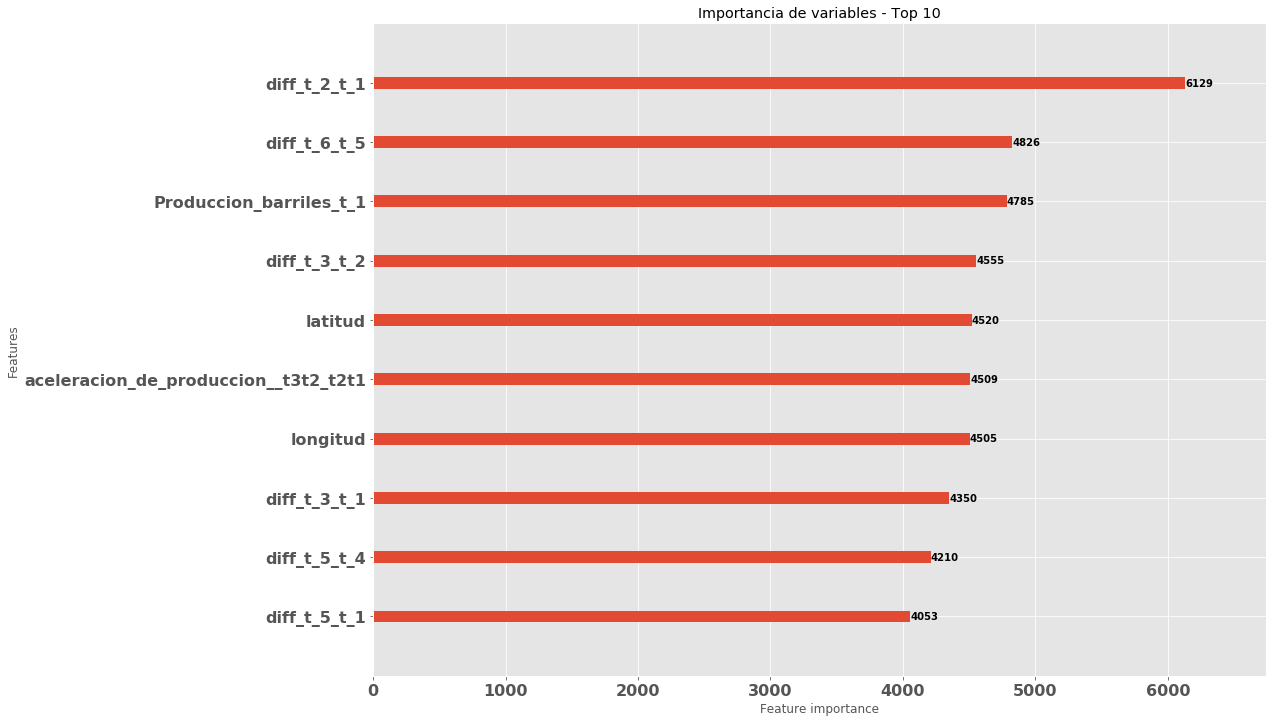

In [258]:
lgb.plot_importance(gbm_pickle, max_num_features=10, title='Importancia de variables - Top 10')

In [314]:
df = None

In [320]:
del df

In [315]:
def forecast(df, n_pred,  num_cols, columna_inicial = 2, lag=7):
    pred=[]
    for i in range(n_pred):
        # genera una nueva fila
        df = pd.concat([df, df.iloc[-1:]], ignore_index=True)
        for j in range(lag - 1):
            # recorrer valores
            df.iloc[-1, j + columna_inicial] = df.iloc[-1, j + 1 + columna_inicial]
            
        gen_cols(df)
        # colocar el valor de la predicción
        valor = gbm_pickle.predict(df[num_cols][-1:])
        print(df[num_cols][-1:].values)
        print(valor)
        
        pred.append(valor)
        df.iloc[-1, columna_inicial + lag - 1] = valor
        
        # calcular las variables que dependen en el tiempo
#         gen_cols(df)
#         # calcular la y_real
#         df.iloc[-1, -1] = valor
        
    return df, pred

In [316]:
for i, val in enumerate(df_forcast.columns):
    if i > 0 and i < 21:
        print(i,val)

1 fecha_produccion
2 Produccion_barriles_t_6
3 Produccion_barriles_t_5
4 Produccion_barriles_t_4
5 Produccion_barriles_t_3
6 Produccion_barriles_t_2
7 Produccion_barriles_t_1
8 Produccion_barriles_t
9 Produccion_barriles_t_mas_1
10 diff_t_6_t_5
11 diff_t_5_t_4
12 diff_t_4_t_3
13 diff_t_3_t_2
14 diff_t_2_t_1
15 diff_t_6_t_1
16 diff_t_5_t_1
17 diff_t_4_t_1
18 diff_t_3_t_1
19 aceleracion_de_produccion _t3t2_t2t1
20 aceleracion_de_produccion _t4t3_t2t1


In [317]:
pozos_vivos

array(['MOLOACAN-440', 'MOLOACAN-459'], dtype=object)

In [323]:
del df_simul

In [325]:
pozos_vivos = df_vivos.Pozo.unique()[55:57]
lag = 7
columna_inicial = 2

df_pred = pd.DataFrame()
for i in range(pozos_vivos.shape[0]):
    #selecciona un pozo vivo de la lista de pozos vivos
    df_prueba = df_forcast[df_forcast.Pozo == pozos_vivos[i]].reset_index(drop=True)
    print(df_prueba.Pozo.unique())
    print('--1--')
    #     df_prueba['y_real'] = df_prueba.Produccion_barriles_t
    #toma los primeros 6 meses
    
    df_simul = df_prueba.iloc[0:6]
#     print(df_simul)
    print('--2--')
    
    #forecast
    n_pred = df_prueba.shape[0] - 6
    print(n_pred)
    print('--3--')
    
    df_simul, pred = forecast(df_simul, n_pred, num_cols)
    
#     print(df_simul,pred)
    print('--4--')
    
    #guarda la misma fecha
    df_simul['fecha_produccion'] = df_prueba['fecha_produccion']
#     print(df_simul)
    print('--5--')
    
    #guarda los resultados en un dataframe
    df_pred = pd.concat([df_pred, df_simul], ignore_index=True)
#     print(df_pred)
    print('--6--')
    print('-------'*10)

['MOLOACAN-646']
--1--
--2--
23
--3--
[[176.11       192.72       186.49       193.06       186.53
  192.34       192.34       192.34       -16.61         6.23
   -6.57         6.53        -5.81       -16.23         0.38
   -5.85         0.72        12.34        -0.76         6.51823519
  189.435      176.11       192.625      186.5        192.89
  181.3        193.06        16.95       189.435      190.64333333
  189.605      190.228      187.875        0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    1.          18.02424772 -94.33220476   0.           0.
    0.           0.           0.           1.           0.
    0.           0.           0.           0.           0.
    0.           0.           1.           0.           0.
    0.           0.           0.           1.        ]]
[359.73596217]
[[ 192.72        186.49        193.06        186.53        192.34
   359.73596217  359.73596217  192

In [312]:
df_pred.shape

(54, 73)

In [250]:
# df_pred.to_pickle('tabla_vivos_2010_forecasting.pkl')

In [251]:
# df_pred.columns

In [252]:
a = df_vivos[['Pozo','fecha_produccion','Produccion_barriles_t']]
a.columns = ['Pozo','fecha_produccion','y_real']

In [253]:
b = df_pred[['Pozo','fecha_produccion','Produccion_barriles_t']]
b.columns = ['Pozo','fecha_produccion','y_estimada']

In [254]:
c = a.merge(b,on=['Pozo','fecha_produccion'])

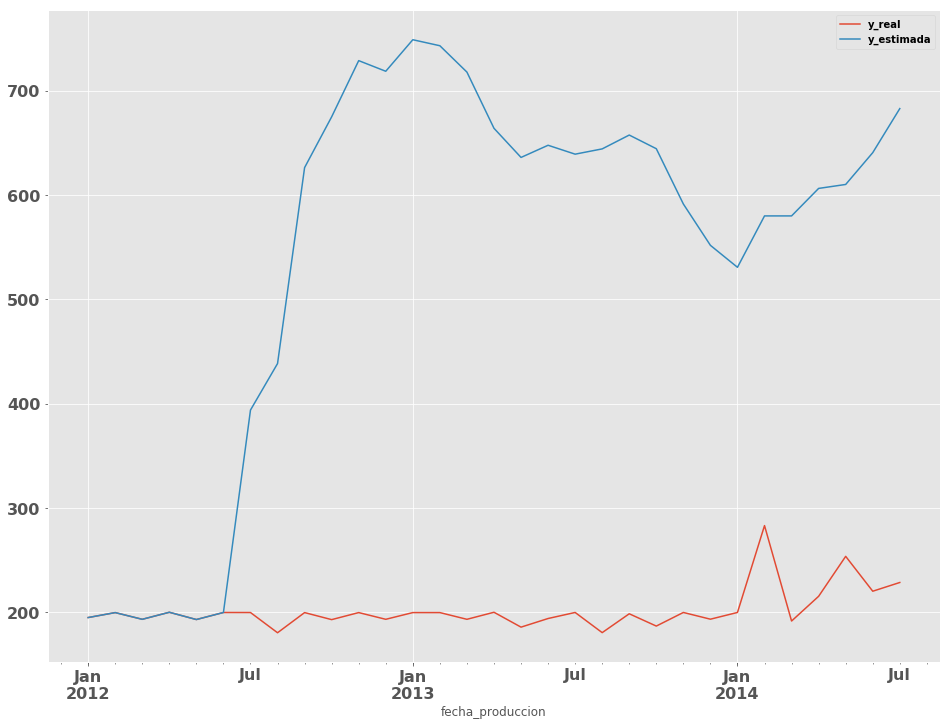

In [255]:
c.groupby('fecha_produccion')[['y_real','y_estimada']].median().plot()